In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import scipy.stats

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'PISA'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]

In [3]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [4]:
def load_subject(subject, data_directory):
    file_suffix = 'cells'
    df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

In [5]:
def find_significant_areas(dictionary, experimental_groups, value, test='mannwhitneyu', alpha=0.05):
    dfs = \
    ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                  dict_results_across_mice=dictionary, 
                                  value=value)
    df_ttest = ace.test_across_groups(dfs,
                                     test=test,
                                     groups=list(experimental_groups.keys()))
    # sort dataframe pvalues of control vs fam and pick the first 20
    columns = df_ttest.loc[:, df_ttest.columns!='area'].columns
    df_sigareas = pd.DataFrame()
    for col in columns:
        df = df_ttest.sort_values(by=col)[['area', col]]
        df_sigareas = pd.concat([df_sigareas, df[df[col]<alpha]['area'].reset_index(drop=True)], axis=1)
    df_sigareas.columns = [col.replace('pval_', '') for col in columns]
    return df_sigareas

In [6]:
# #NB: Run only if file does not exist or needs to be regenerated
# dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject=subject,
#                                                                                                data_directory=data_directory), 
#                                                                           vol=volumes, 
#                                                                           level=8) for subject in subjects}
# np.save('dict_results/newvolumes/dict_results_across_mice_PISA.npy', dict_results_across_mice)

In [7]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_PISA.npy', 
                                   allow_pickle=True).item()
# reformat dictionary and subjects
old_keys = list(dict_results_across_mice.keys())
for key in old_keys:
    group = key.split('_')[-1] if key.split('_')[-1][-1]!='2' else key.split('_')[-1][:-1]
    number = key.split('_')[0]
    new_key = 'BL'+number+group
    dict_results_across_mice[new_key] = dict_results_across_mice[key]
    del dict_results_across_mice[key]
    
#remove BL12_noshock due to biased number of cells
del dict_results_across_mice['BL12noshock']

# del dict_results_across_mice['BL22demonstrator']

subjects = list(dict_results_across_mice.keys())

In [8]:
for subject in subjects:
    dict_results_across_mice[subject].to_csv(data_directory+subject+'.csv', 
                                       index=False)

In [9]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects,
                                                group_labels=['noshock','demonstrator', 'observer'])

In [10]:
df_noshock_ncells, df_demonstrator_ncells, df_observer_ncells = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [11]:
df_noshock_ncells.set_index('area').sum()

BL13noshock    406199
BL1noshock     151046
BL20noshock     86430
BL19noshock    168780
BL15noshock     53309
BL11noshock    124578
BL7noshock     186913
dtype: int64

In [12]:
df_demonstrator_ncells.set_index('area').sum()

BL4demonstrator     603790
BL9demonstrator     138976
BL17demonstrator    196154
BL22demonstrator     82403
BL6demonstrator     242989
BL14demonstrator    509601
BL3demonstrator     467926
dtype: int64

In [13]:
df_observer_ncells.set_index('area').sum()

BL2observer     577030
BL16observer    408036
BL10observer    271418
BL5observer     401857
BL18observer    253538
BL8observer     339530
BL21observer    169712
dtype: int64

# Calculate t-tests number of cell across groups per area

In [14]:
df_noshock_ncells, df_demonstrator_ncells, df_observer_ncells = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups([df_noshock_ncells,
                                          df_demonstrator_ncells,
                                          df_observer_ncells],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'],
                                        test='mannwhitneyu')

In [15]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='density',
                       test='mannwhitneyu',
                      alpha=0.01).to_csv('significant_areas_non_param_test_density_001.csv',
                                        index=False)
df_ttest_ncells.to_csv('df_nonparametrictest_ncells.csv', index=False)

In [16]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='energy',
                       test='mannwhitneyu',
                      alpha=0.05)

,noshock_vs_demonstrator,noshock_vs_observer,demonstrator_vs_observer
0,Lateral strip of striatum,Lateral strip of striatum,Suprachiasmatic preoptic nucleus
1,Substantia nigra lateral part,Substantia nigra lateral part,Substantia nigra lateral part
2,Intercollicular nucleus,Intercollicular nucleus,Retroethmoid nucleus
3,Suprachiasmatic preoptic nucleus,Anterior hypothalamic area,Anterior hypothalamic area
4,Anterior hypothalamic area,Nucleus circularis,Nucleus circularis
...,...,...,...
71,NaN,Posterior hypothalamic nucleus,NaN
72,NaN,Preparasubthalamic nucleus,NaN
73,NaN,Medial preoptic area,NaN
74,NaN,Prelimbic area,NaN


In [17]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='relative_density',
                       test='mannwhitneyu',
                      alpha=0.05)

,noshock_vs_demonstrator,noshock_vs_observer,demonstrator_vs_observer
0,Lateral strip of striatum,Lateral strip of striatum,Pineal body
1,Anterior hypothalamic area,Pineal body,Nucleus circularis
2,Nucleus circularis,Retroethmoid nucleus,Anterior hypothalamic area
3,Pineal body,Substantia nigra lateral part,Intercollicular nucleus
4,Suprachiasmatic preoptic nucleus,Nucleus circularis,Retroethmoid nucleus
5,Intercollicular nucleus,Anterior hypothalamic area,Suprachiasmatic preoptic nucleus
6,Cortical amygdalar area,Suprachiasmatic preoptic nucleus,Substantia nigra lateral part
7,Retroethmoid nucleus,Intercollicular nucleus,Lateral strip of striatum
8,Substantia nigra lateral part,Posterolateral visual area,Bed nucleus of the anterior commissure
9,Red nucleus,Caudoputamen,Lateral hypothalamic area


In [18]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all')

In [19]:
#sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_noshock_vs_demonstrator')[['area', 'pval_noshock_vs_demonstrator']][0:20].set_index('area')

,pval_noshock_vs_demonstrator
area,
Taenia tecta,0.00246895
Cortical amygdalar area,0.00246895
Piriform area,0.00246895
Posterolateral visual area,0.00361311
Anterior olfactory nucleus,0.00364518
Claustrum,0.00530167
Piriform-amygdalar area,0.00530167
Basomedial amygdalar nucleus,0.0075968
Anteromedial visual area,0.0075968


In [20]:
#sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_noshock_vs_observer')[['area', 'pval_noshock_vs_observer']][0:30].set_index('area')

,pval_noshock_vs_observer
area,
Posterolateral visual area,0.00107035
Parataenial nucleus,0.00108251
Dorsomedial nucleus of the hypothalamus,0.00108251
Anterior olfactory nucleus,0.00164726
Taenia tecta,0.00164726
Retrosplenial area,0.00164726
Anteromedial visual area,0.00246895
Lateral visual area,0.00246895
Basomedial amygdalar nucleus,0.00246895


In [21]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_demonstrator_vs_observer')[['area', 'pval_demonstrator_vs_observer']][0:10].set_index('area')

,pval_demonstrator_vs_observer
area,
Preparasubthalamic nucleus,0.0483488
Pedunculopontine nucleus,0.0626005
Lateral habenula,0.0626005
Globus pallidus internal segment,0.0626005
Ventral tegmental area,0.0799321
Midbrain reticular nucleus retrorubral area,0.0799321
Perireunensis nucleus,0.100172
Intermediodorsal nucleus of the thalamus,0.100668
Peripeduncular nucleus,0.100668


# Correlations across number of cells

In [22]:
corr_matrix_noshock_ncells = ace.cross_corr(df_noshock_ncells)
corr_matrix_demonstrator_ncells = ace.cross_corr(df_demonstrator_ncells)
corr_matrix_observer_ncells = ace.cross_corr(df_observer_ncells)

Text(0.5, 1.0, 'OBSERVER')

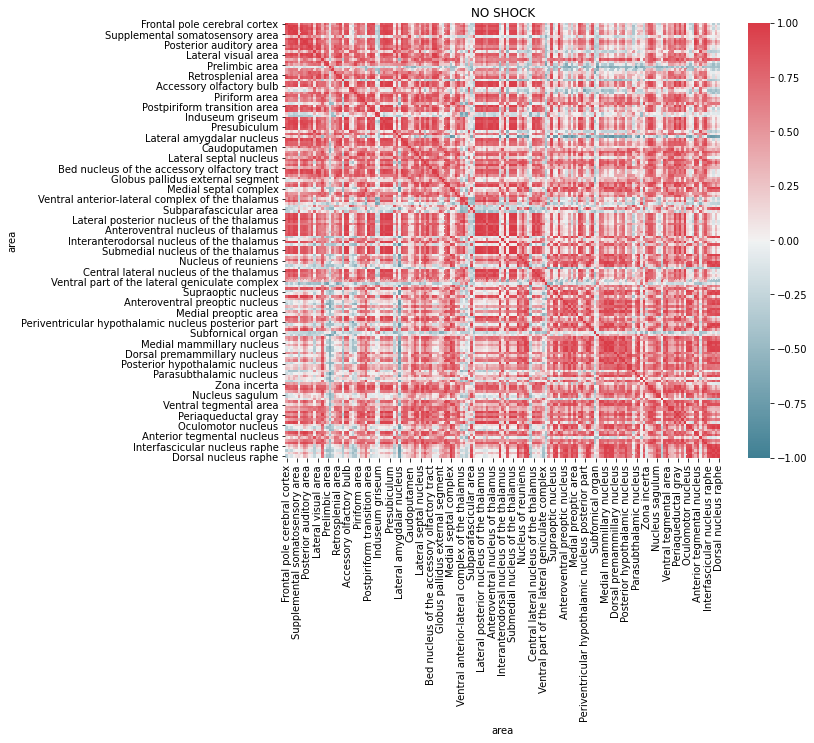

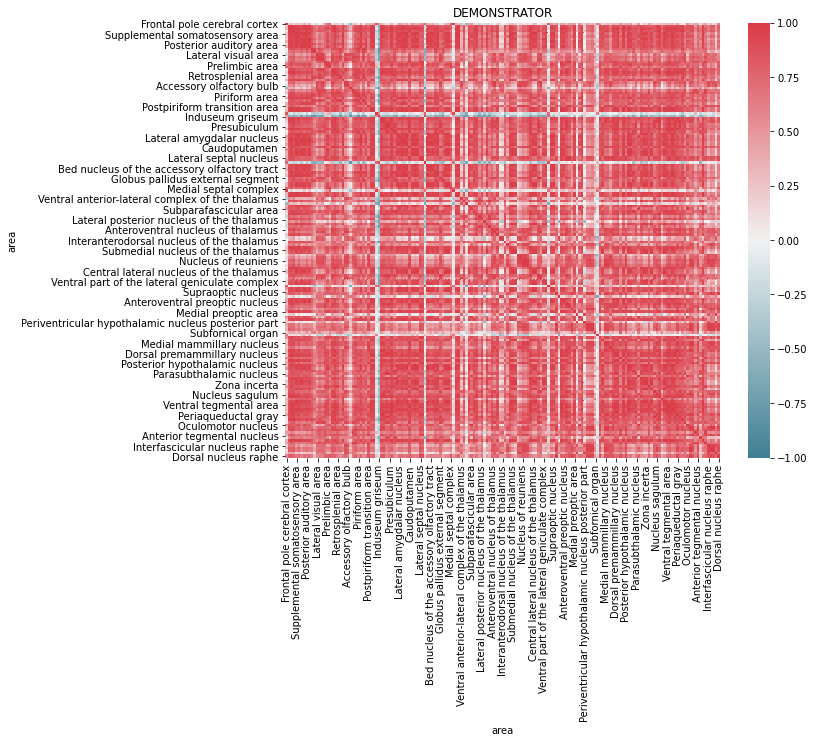

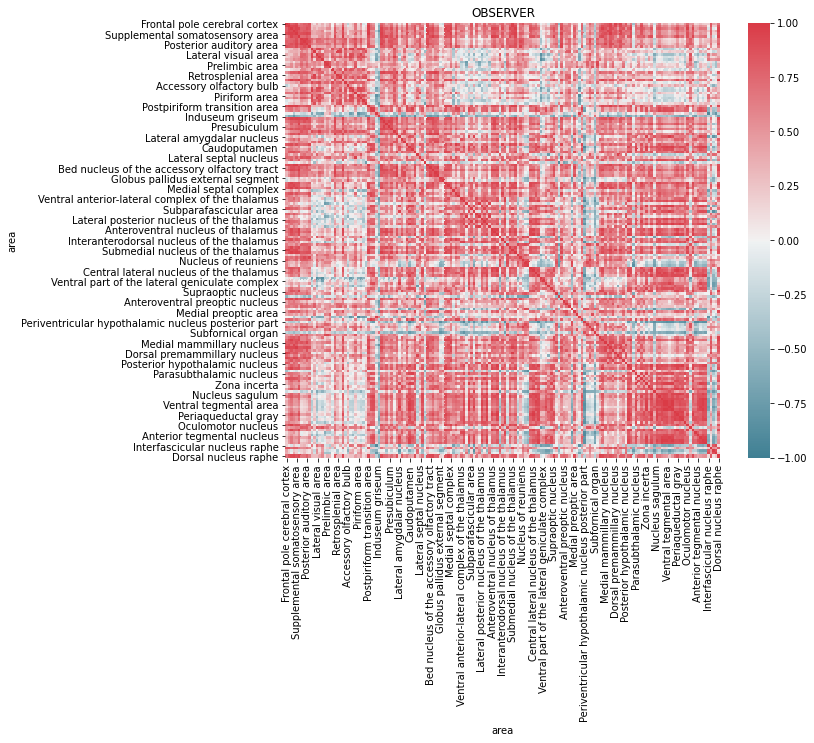

In [23]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_noshock_ncells),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('NO SHOCK')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_demonstrator_ncells),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('DEMONSTRATOR')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_observer_ncells),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('OBSERVER')

# Calculate t-tests density across groups per area

In [24]:
df_noshock_density, df_demonstrator_density, df_observer_density = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='density')
df_ttest_density = ace.test_across_groups([df_noshock_density,
                                          df_demonstrator_density,
                                          df_observer_density],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'],
                                        test='mannwhitneyu')
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_density = df_ttest_density.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])

In [25]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='density',
                       test='mannwhitneyu',
                      alpha=0.05).to_csv('significant_areas_non_param_test_density.csv',
                                        index=False)
df_ttest_density.to_csv('df_nonparametrictest_density.csv', index=False)

# Calculate t-tests energy across groups per area

In [26]:
df_noshock_energy, df_demonstrator_energy, df_observer_energy = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='energy')
df_ttest_energy = ace.test_across_groups([df_noshock_energy,
                                          df_demonstrator_energy,
                                          df_observer_energy],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'],
                                        test='mannwhitneyu')
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])


In [27]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='energy',
                       test='mannwhitneyu',
                      alpha=0.05).to_csv('significant_areas_non_param_test_energy.csv',
                                        index=False)
df_ttest_ncells.to_csv('df_nonparametrictest_energy.csv', index=False)

In [28]:
df_ttest_not_null_energy.sort_values(
    by='pval_noshock_vs_demonstrator')[['area', 'pval_noshock_vs_demonstrator']][0:20].set_index('area')

,pval_noshock_vs_demonstrator
area,
Lateral strip of striatum,0.00108251
Substantia nigra lateral part,0.00108251
Intercollicular nucleus,0.00108251
Suprachiasmatic preoptic nucleus,0.00108251
Anterior hypothalamic area,0.00108251
Nucleus circularis,0.00108251
Pineal body,0.00108251
Retroethmoid nucleus,0.00108251
Anterior olfactory nucleus,0.0107254


In [29]:
df_ttest_not_null_energy.sort_values(
    by='pval_noshock_vs_observer')[['area', 'pval_noshock_vs_observer']][0:45].set_index('area')

,pval_noshock_vs_observer
area,
Lateral strip of striatum,0.00108251
Substantia nigra lateral part,0.00108251
Intercollicular nucleus,0.00108251
Anterior hypothalamic area,0.00108251
Nucleus circularis,0.00108251
Pineal body,0.00108251
Suprachiasmatic preoptic nucleus,0.00108251
Retroethmoid nucleus,0.00108251
Posterolateral visual area,0.00164726


In [30]:
df_ttest_not_null_energy.sort_values(
    by='pval_demonstrator_vs_observer')[['area', 'pval_demonstrator_vs_observer']][0:10].set_index('area')

,pval_demonstrator_vs_observer
area,
Suprachiasmatic preoptic nucleus,0.00108251
Substantia nigra lateral part,0.00108251
Retroethmoid nucleus,0.00108251
Anterior hypothalamic area,0.00108251
Nucleus circularis,0.00108251
Lateral strip of striatum,0.00108251
Intercollicular nucleus,0.00108251
Pineal body,0.00108251
Bed nucleus of the anterior commissure,0.0797025


In [31]:
corr_matrix_noshock_energy = ace.cross_corr(df_noshock_energy)
corr_matrix_demonstrator_energy = ace.cross_corr(df_demonstrator_energy)
corr_matrix_observer_energy = ace.cross_corr(df_observer_energy)

Text(0.5, 1.0, 'OBSERVER')

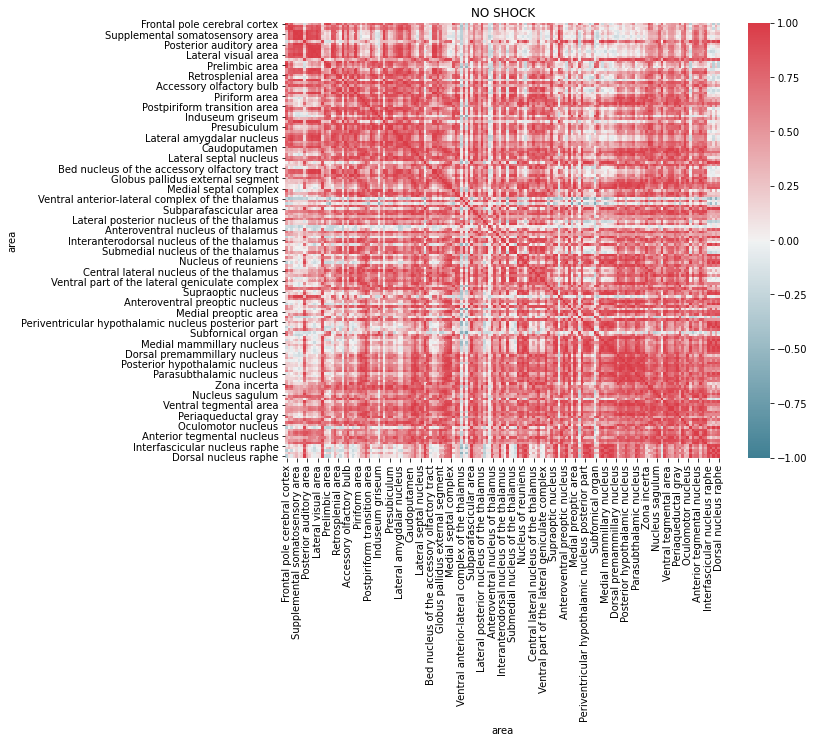

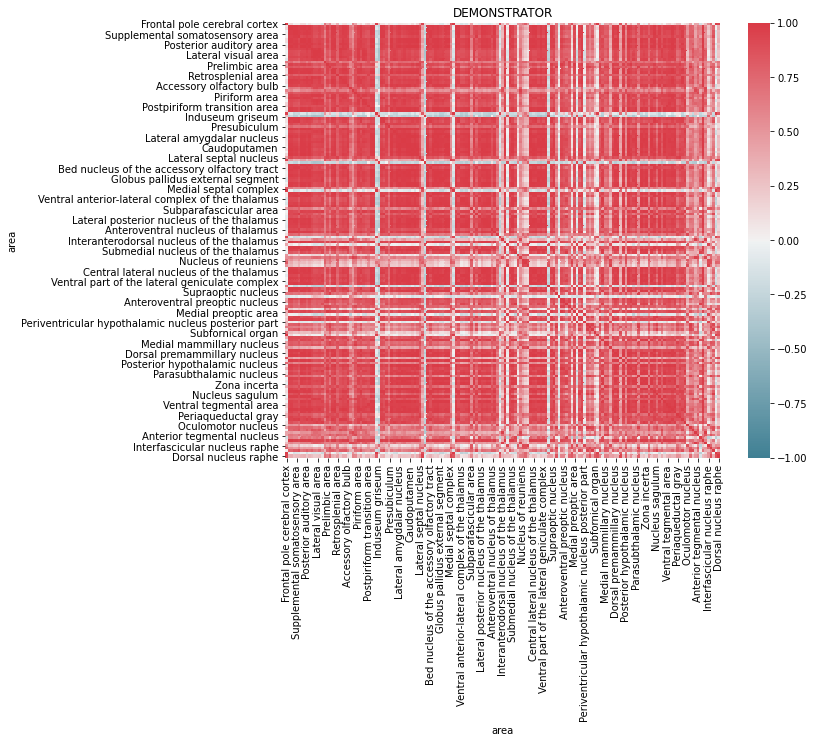

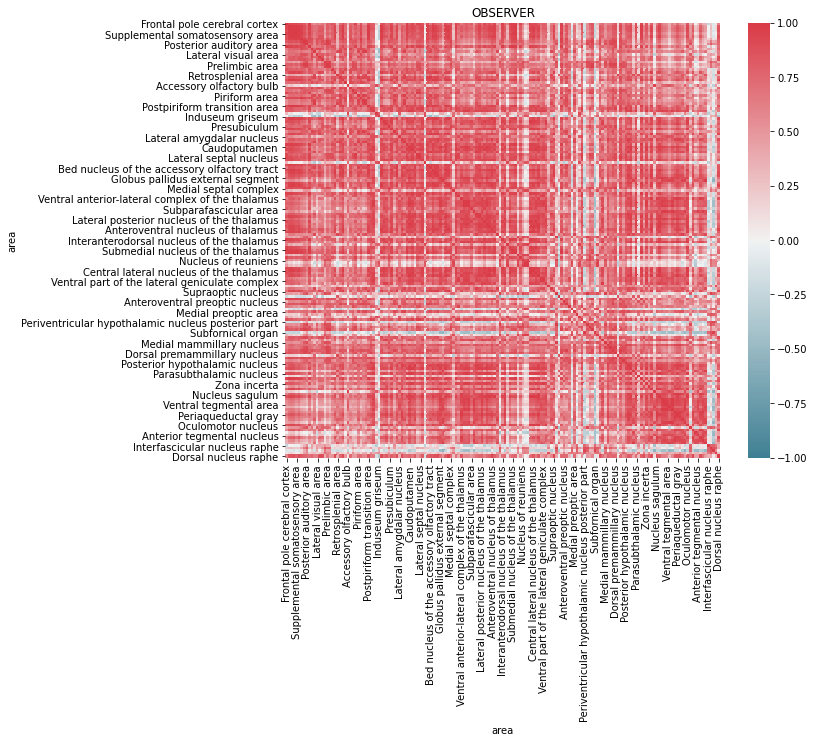

In [32]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_noshock_energy),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('NO SHOCK')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_demonstrator_energy),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('DEMONSTRATOR')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_observer_energy),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('OBSERVER')

# Calculate relative density

In [33]:
df_noshock_rd, df_demonstrator_rd, df_observer_rd = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='relative_density')
df_ttest_rd = ace.test_across_groups([df_noshock_rd,
                                          df_demonstrator_rd,
                                          df_observer_rd],
                                        groups=['noshock',
                                               'demonstrator',
                                               'observer'],
                                        test='mannwhitneyu')
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_rd = df_ttest_rd.dropna(axis=0,
                                   how='all',
                                   subset=['pval_noshock_vs_demonstrator',
                                          'pval_noshock_vs_observer',
                                          'pval_demonstrator_vs_observer'])

In [34]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='relative_density',
                       test='mannwhitneyu',
                      alpha=0.05).to_csv('significant_areas_non_param_test_relative_density.csv',
                                        index=False)
df_ttest_ncells.to_csv('df_nonparametrictest_relative_density.csv', index=False)

In [35]:
df_ttest_not_null_rd.sort_values(
    by='pval_noshock_vs_demonstrator')[['area', 'pval_noshock_vs_demonstrator']][0:30].set_index('area')

,pval_noshock_vs_demonstrator
area,
Lateral strip of striatum,0.00108251
Anterior hypothalamic area,0.00108251
Nucleus circularis,0.00108251
Pineal body,0.00108251
Suprachiasmatic preoptic nucleus,0.00108251
Intercollicular nucleus,0.00108251
Cortical amygdalar area,0.00108251
Retroethmoid nucleus,0.00108251
Substantia nigra lateral part,0.00108251


In [36]:
df_ttest_not_null_rd.sort_values(
    by='pval_noshock_vs_observer')[['area', 'pval_noshock_vs_observer']][0:20].set_index('area')

,pval_noshock_vs_observer
area,
Lateral strip of striatum,0.00108251
Pineal body,0.00108251
Retroethmoid nucleus,0.00108251
Substantia nigra lateral part,0.00108251
Nucleus circularis,0.00108251
Anterior hypothalamic area,0.00108251
Suprachiasmatic preoptic nucleus,0.00108251
Intercollicular nucleus,0.00108251
Posterolateral visual area,0.00246895


In [37]:
df_ttest_not_null_rd.sort_values(
    by='pval_demonstrator_vs_observer')[['area', 'pval_demonstrator_vs_observer']][0:20].set_index('area')

,pval_demonstrator_vs_observer
area,
Pineal body,0.00108251
Nucleus circularis,0.00108251
Anterior hypothalamic area,0.00108251
Intercollicular nucleus,0.00108251
Retroethmoid nucleus,0.00108251
Suprachiasmatic preoptic nucleus,0.00108251
Substantia nigra lateral part,0.00108251
Lateral strip of striatum,0.00108251
Bed nucleus of the anterior commissure,0.020346


In [38]:
corr_matrix_noshock_rd = ace.cross_corr(df_noshock_rd)
corr_matrix_demonstrator_rd = ace.cross_corr(df_demonstrator_rd)
corr_matrix_observer_rd = ace.cross_corr(df_observer_rd)

Text(0.5, 1.0, 'OBSERVER')

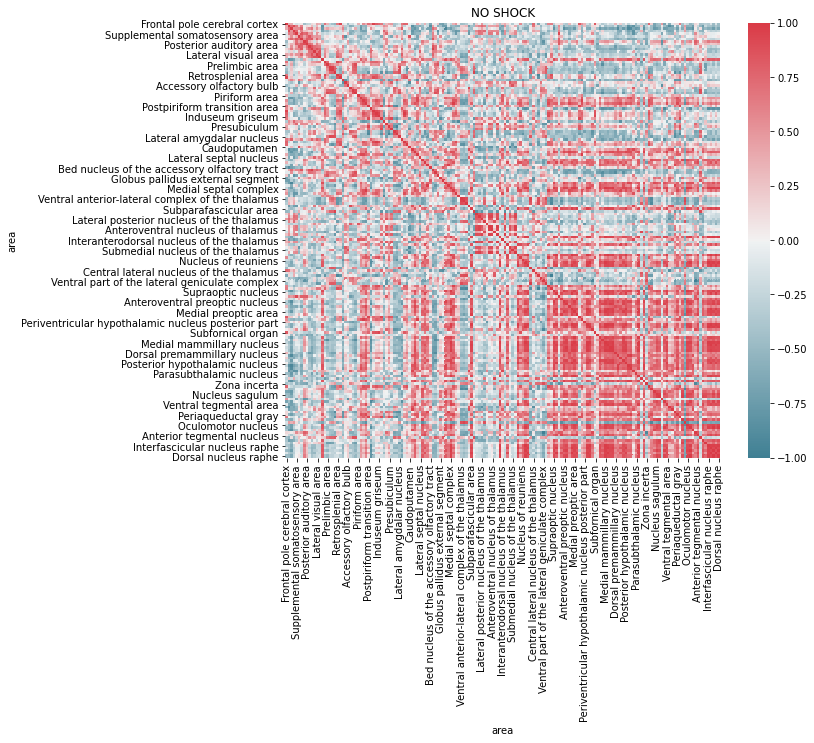

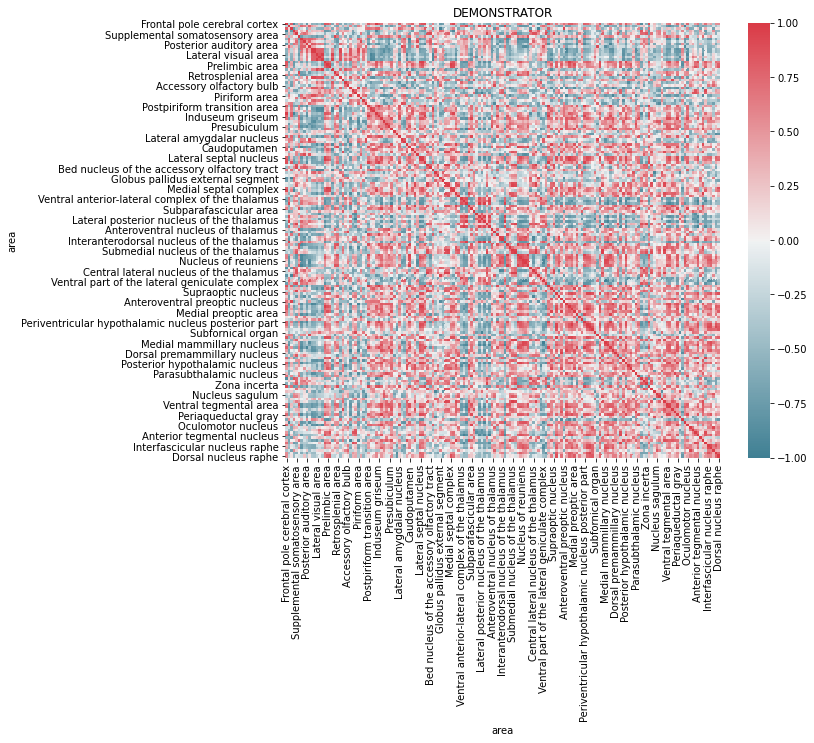

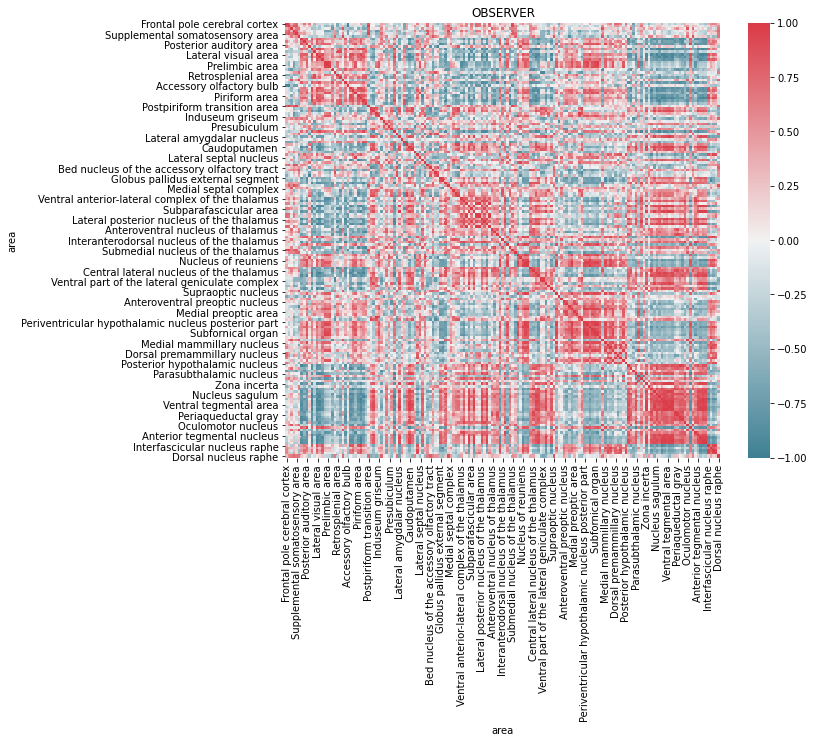

In [39]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_noshock_rd),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('NO SHOCK')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_demonstrator_rd),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('DEMONSTRATOR')
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(ace.cross_corr(df_observer_rd),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('OBSERVER')

# Correlation with behavior

In [40]:
#load behavioral data and removing mouse 12
behavior = pd.read_excel('/home/stella/Documents/Torino/projects/SexualImprinting/PISA/subs_FOS_EC.xlsx', 
                         index_col=0).drop(11)

In [41]:
behavior

,cage,label,sex,geno,role,EC_amp_0,EC_lat_0,mouse
0,CLT_5,000,M,WT,NOS,1.055338,2.05,BL15noshock
1,CLT_3,R00,M,WT,NOS,-0.796098,3.00,BL7noshock
2,CLT_3,0R0,M,WT,OBS,1.067573,2.40,BL2observer
3,CLT_9,R00,F,WT,OBS,1.114847,1.70,BL21observer
4,CLT_1,000,F,WT,OBS,3.932445,1.00,BL8observer
5,CLT_7,00R,F,WT,OBS,9.881270,1.70,BL18observer
6,CLT_2,0R0,F,WT,NOS,-0.534185,1.20,BL1noshock
7,CLT_7,000,F,WT,NOS,0.140642,2.05,BL19noshock
8,CLT_6,0R0,M,WT,OBS,1.250897,2.80,BL10observer
9,CLT_6,00B,M,WT,NOS,0.920259,1.15,BL11noshock


In [42]:
behavior_noshock = behavior[behavior['role'] == 'NOS'][['EC_amp_0', 'EC_lat_0', 'mouse']].reset_index(drop=True)
behavior_observer = behavior[behavior['role'] == 'OBS'][['EC_amp_0', 'EC_lat_0', 'mouse']].reset_index(drop=True)

In [43]:
behavior_observer

,EC_amp_0,EC_lat_0,mouse
0,1.067573,2.40,BL2observer
1,1.114847,1.70,BL21observer
2,3.932445,1.00,BL8observer
3,9.881270,1.70,BL18observer
4,1.250897,2.80,BL10observer
5,2.324617,1.40,BL5observer
6,1.573428,2.05,BL16observer


<AxesSubplot:xlabel='geno', ylabel='EC_lat_0'>

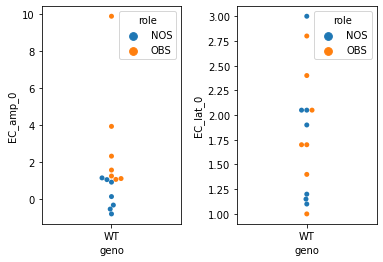

In [44]:
# make plot
fig, axes = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.4)
# Draw a categorical scatterplot to show each observation
sns.swarmplot(data=behavior, y="EC_amp_0",x='geno',
                   hue="role", ax=axes[0])
sns.swarmplot(data=behavior, y="EC_lat_0",x='geno',
                   hue="role", ax=axes[1])

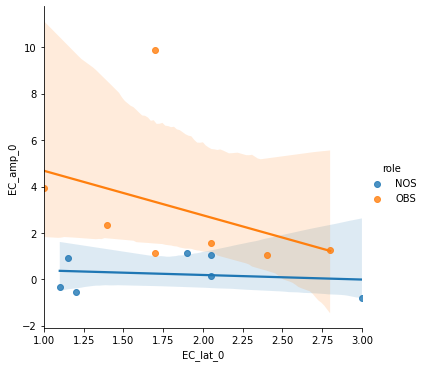

In [45]:
g = sns.lmplot(
    data=behavior,
    x="EC_lat_0", y="EC_amp_0", hue="role",
    height=5
)

# Plots corr tests

In [46]:
significant_areas = ace.select_significant_areas(dictionary=dict_results_across_mice, 
                                             experimental_groups=experimental_groups, 
                                             batch='PISA',
                                             test='mannwhitneyu', 
                                             threshold_test=0.05,
                                             threshold_pls=2.56,
                                             value_test='density', 
                                             value_pls='relative_density')

In [47]:
areas_ttest_acronyms = set([volumes[volumes['safe_name']==area]['acronym'].values[0] \
                            for area in significant_areas])

In [50]:
#reorder behavioral data based on df_group
behavior_observer = behavior_observer.set_index('mouse').\
            loc[df_observer_density.set_index('area').columns.to_list(), :].reset_index()
behavior_noshock = behavior_noshock.set_index('mouse').\
            loc[df_noshock_density.set_index('area').columns.to_list(), :].reset_index()

/home/stella/anaconda2/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/stella/anaconda2/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<AxesSubplot:>

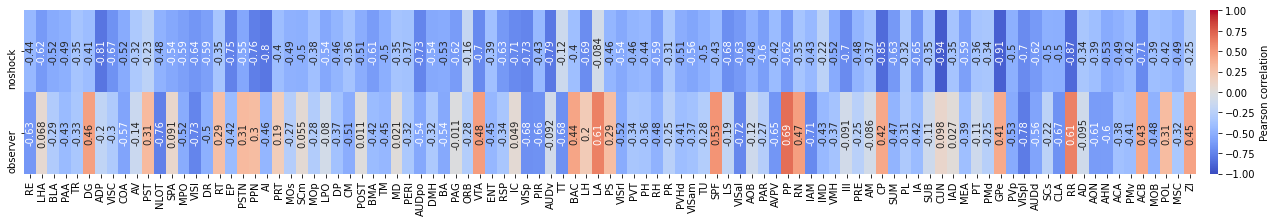

In [58]:
corr_ncells, pvalue = ace.compute_corr_pvalue(dfs_groups=[df_noshock_density, df_observer_density], 
                                   group_labels=['noshock', 'observer'],
                                   volumes=volumes, 
                                   behavioral_data=[behavior_noshock['EC_amp_0'],
                                                      behavior_observer['EC_amp_0']],
                                   significant_areas=list(areas_ttest_acronyms))
# put X if pvalue is significant
fig, axes = plt.subplots(figsize=(25,3))
sns.heatmap(corr_ncells, ax=axes, cmap='coolwarm', vmin=-1, vmax=+1, 
                             cbar_kws={'label': 'Pearson correlation',"pad":0.01},
           annot=True, annot_kws={'rotation': 90})

/home/stella/anaconda2/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/stella/anaconda2/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<AxesSubplot:>

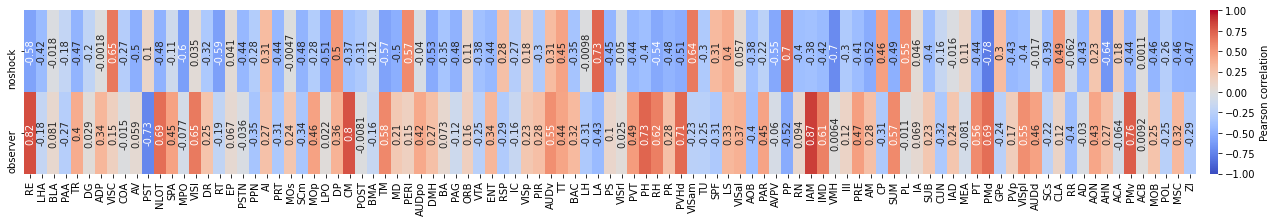

In [63]:
corr_ncells, pvalue = ace.compute_corr_pvalue(dfs_groups=[df_noshock_density, df_observer_density], 
                                   group_labels=['noshock', 'observer'],
                                   volumes=volumes, 
                                   behavioral_data=[behavior_noshock['EC_lat_0'],
                                                      behavior_observer['EC_lat_0']],
                                   significant_areas=list(areas_ttest_acronyms))
# put X if pvalue is significant
fig, axes = plt.subplots(figsize=(25,3))
sns.heatmap(corr_ncells, ax=axes, cmap='coolwarm', vmin=-1, vmax=+1, 
                             cbar_kws={'label': 'Pearson correlation',"pad":0.01},
           annot=True, annot_kws={'rotation': 90})

# TODO: check delta tra correlazioni nei gruppi + distribuzioni correlazioni tra gruppi

Text(0.5, 1.0, 'Observer')

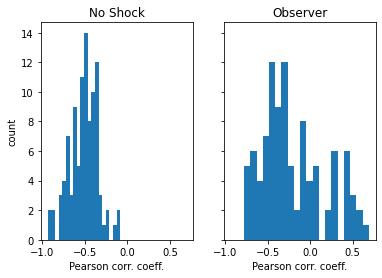

In [52]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
axes[0].hist(corr_ncells.T['noshock'], bins=20)
axes[1].hist(corr_ncells.T['observer'], bins=20)
axes[0].set_ylabel('count')
axes[0].set_xlabel('Pearson corr. coeff.')
axes[1].set_xlabel('Pearson corr. coeff.')
axes[0].set_title('No Shock')
axes[1].set_title('Observer')

# Plots correlation density vs EC_amp_0 delle aree viste da ste

In [53]:
aree_ste = ['Agranular insular area',
           'Retrosplenial area',
           'Anterior olfactory nucleus',
           'Postsubiculum',
           'Presubiculum',
           'Claustrum',
           'Endopiriform nucleus',
           'Basolateral amygdalar nucleus',
           'Intercalated amygdalar nucleus',
           'Medial amygdalar nucleus',
           'Lateral hypothalamic area',
           'Superior colliculus sensory related',
           'Inferior colliculus']

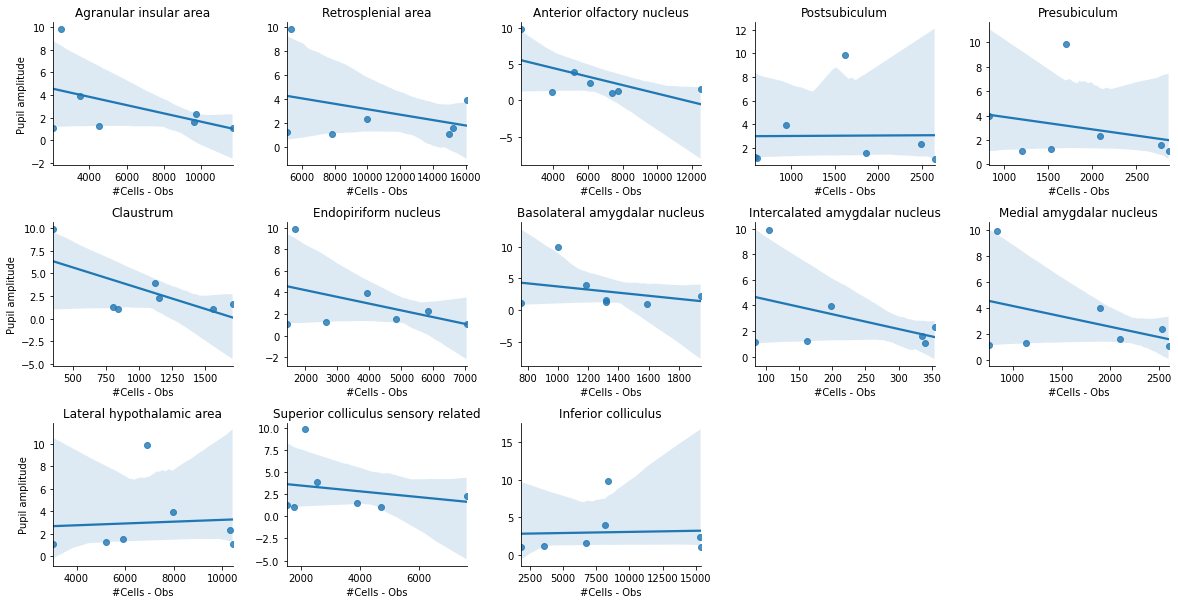

In [55]:
fig, axes  = plt.subplots(3,5, figsize=(20,10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
for i, area in enumerate(aree_ste):
    data = pd.DataFrame(columns=['n_cells', 'behavior', 'mouse'])
    data['n_cells'] = df_observer_ncells.set_index('area').T[area].values
    data['subject'] = df_observer_ncells.set_index('area').T[area].index
    data['behavior'] = [behavior_observer[behavior_observer['mouse']==mouse]["EC_amp_0"].item() \
                        for mouse in data['subject'].values]
    g = sns.regplot(data=data, x='n_cells', 
                   y='behavior', ax=axes.flat[i],
                   fit_reg=True)
    axes.flat[i].set_title(area)
    axes.flat[i].set_title(area)
    axes.flat[i].spines['top'].set_visible(False)
    axes.flat[i].spines['right'].set_visible(False)
    axes.flat[i].set_xlabel("#Cells - Obs")
    if i not in [0,5,10]:
        axes.flat[i].set_ylabel("")
    else:
        axes.flat[i].set_ylabel("Pupil amplitude")
fig.delaxes(axes.flat[13])
fig.delaxes(axes.flat[14])
plt.savefig('correlation_pupil_amplitude.png')
plt.savefig('correlation_pupil_amplitude.svg')

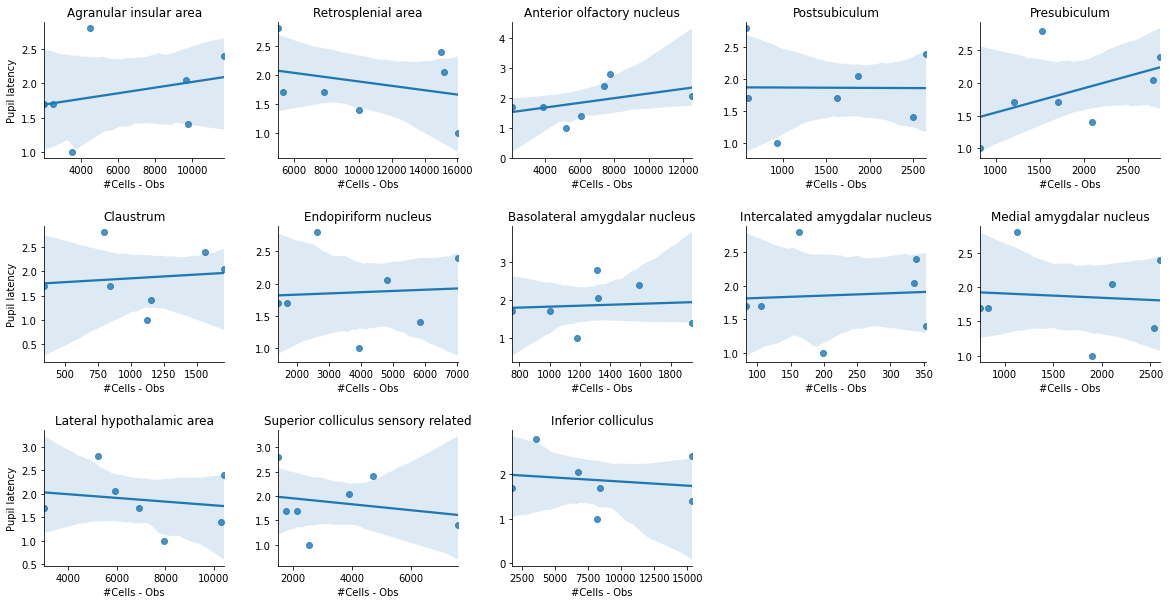

In [56]:
fig, axes  = plt.subplots(3,5, figsize=(20,10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)
for i, area in enumerate(aree_ste):
    data = pd.DataFrame(columns=['n_cells', 'behavior'])
    data['n_cells'] = df_observer_ncells.set_index('area').T[area].values
    data['subject'] = df_observer_ncells.set_index('area').T[area].index
    data['behavior'] = [behavior_observer[behavior_observer['mouse']==mouse]["EC_lat_0"].item() \
                        for mouse in data['subject'].values]
    g = sns.regplot(data=data, x='n_cells', 
                   y='behavior', ax=axes.flat[i])
    axes.flat[i].set_title(area)
    axes.flat[i].set_title(area)
    axes.flat[i].spines['top'].set_visible(False)
    axes.flat[i].spines['right'].set_visible(False)
    axes.flat[i].set_xlabel("#Cells - Obs")
    if i not in [0,5,10]:
        axes.flat[i].set_ylabel("")
    else:
        axes.flat[i].set_ylabel("Pupil latency")
fig.delaxes(axes.flat[13])
fig.delaxes(axes.flat[14])
plt.savefig('correlation_pupil_latency.png')
plt.savefig('correlation_pupil_latency.svg')

#  Overlap aree attivate (noshock vs observer) vs (noshock vs demonstrator)

In [ ]:
area_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_noshock_vs_demonstrator']<0.05]['area'].values])
area_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_noshock_vs_observer']<0.05]['area'].values])

In [ ]:
# intersection significant areas with relative density
area_noshock_vs_demonstrator.intersection(area_noshock_vs_observer) 

In [ ]:
# areas that are significant in demonstrator but not in observer
area_noshock_vs_demonstrator.difference(area_noshock_vs_observer) 

In [ ]:
# areas significant in observer and not in demonstrator
area_noshock_vs_observer.difference(area_noshock_vs_demonstrator) 

# Histograms

## relative density

In [ ]:
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_rd[df_ttest_not_null_rd['pval_demonstrator_vs_observer']<0.05]['area'].values]))
areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'relative density', 'group'])
fam = pd.DataFrame(columns=['area', 'relative density', 'group'])
unfam = pd.DataFrame(columns=['area', 'relative density', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['relative density'] = [df_noshock_rd.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['relative density'] = [df_demonstrator_rd.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['relative density'] = [df_observer_rd.set_index('area').loc[area].mean() for area in areas_ttest]
without_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, gridspec_kw={'hspace':0.05}, figsize=(20,3))
sns.barplot(
    data=without_father,
    x="area", y="relative density", hue="group", palette="Accent", ax=ax)
ax.legend().set_title('')

## number of cells

In [ ]:
##### stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values]))[:45]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['number of cells'] = [df_noshock_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['number of cells'] = [df_demonstrator_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['number of cells'] = [df_observer_ncells.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

#stack 2

areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values]))[45:]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['number of cells'] = [df_noshock_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['number of cells'] = [df_demonstrator_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['number of cells'] = [df_observer_ncells.set_index('area').loc[area].mean() for area in areas_ttest]
without_father2 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=2, gridspec_kw={'hspace':0.2}, figsize=(20,5), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax[0])
ax[0].set_xlabel('')
sns.barplot(
    data=without_father2,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax[1])
ax[1].set_xlabel('')
ax[1].legend_.remove()
ax[0].legend().set_title('')

In [ ]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['number of cells'] = [df_noshock_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['number of cells'] = [df_demonstrator_ncells.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['number of cells'] = [df_observer_ncells.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(26,3), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax)
ax.legend().set_title('')

## density

In [ ]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_demonstrator_vs_observer']<0.05]['area'].values]))[:45]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'density', 'group'])
fam = pd.DataFrame(columns=['area', 'density', 'group'])
unfam = pd.DataFrame(columns=['area', 'density', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['density'] = [df_noshock_density.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['density'] = [df_demonstrator_density.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['density'] = [df_observer_density.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

#stack 2

areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_demonstrator_vs_observer']<0.05]['area'].values]))[45:]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]


control = pd.DataFrame(columns=['area', 'density', 'group'])
fam = pd.DataFrame(columns=['area', 'density', 'group'])
unfam = pd.DataFrame(columns=['area', 'density', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['density'] = [df_noshock_density.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['density'] = [df_demonstrator_density.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['density'] = [df_observer_density.set_index('area').loc[area].mean() for area in areas_ttest]
without_father2 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=2, gridspec_kw={'hspace':0.2}, figsize=(22,5), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="density", hue="group", palette="Accent", ax=ax[0])
ax[0].set_xlabel('')
sns.barplot(
    data=without_father2,
    x="area", y="density", hue="group", palette="Accent", ax=ax[1])
ax[1].legend_.remove()
ax[1].set_xlabel('')
ax[0].legend().set_title('')

In [ ]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_density[df_ttest_not_null_density['pval_demonstrator_vs_observer']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'density', 'group'])
fam = pd.DataFrame(columns=['area', 'density', 'group'])
unfam = pd.DataFrame(columns=['area', 'density', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['density'] = [df_noshock_density.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['density'] = [df_demonstrator_density.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['density'] = [df_observer_density.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(26,3), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="density", hue="group", palette="Accent", ax=ax)
ax.legend().set_title('')

## energy

In [ ]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_demonstrator_vs_observer']<0.05]['area'].values]))[:40]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['energy'] = [df_noshock_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['energy'] = [df_demonstrator_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['energy'] = [df_observer_energy.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

#stack 2

areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_demonstrator_vs_observer']<0.05]['area'].values]))[40:]

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]


control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['energy'] = [df_noshock_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['energy'] = [df_demonstrator_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['energy'] = [df_observer_energy.set_index('area').loc[area].mean() for area in areas_ttest]
without_father2 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=2, gridspec_kw={'hspace':0.28}, figsize=(20,5), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="energy", hue="group", palette="Accent", ax=ax[0])
ax[0].set_xlabel('')
ax[0].legend().set_title('')
sns.barplot(
    data=without_father2,
    x="area", y="energy", hue="group", palette="Accent", ax=ax[1])
ax[1].legend_.remove()
ax[1].set_xlabel('')

In [ ]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_demonstrator']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_noshock_vs_observer']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_demonstrator_vs_observer']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['noshock' for area in areas_ttest]
control['energy'] = [df_noshock_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['demonstrator' for area in areas_ttest]
fam['energy'] = [df_demonstrator_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['observer' for area in areas_ttest]
unfam['energy'] = [df_observer_energy.set_index('area').loc[area].mean() for area in areas_ttest]
without_father1 = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(26,3), sharey=True)
sns.barplot(
    data=without_father1,
    x="area", y="energy", hue="group", palette="Accent", ax=ax)

# Intersection significant areas (ttest ncells vs energy vs dens vs rel_dens) 
for 
- control vs observer 
- control vs demonstrator
- observer vs demonstrator

In [ ]:
ncells_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_ncells[
    df_ttest_not_null_ncells['pval_noshock_vs_observer']<0.05]['area'].values])

energy_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_energy[
    df_ttest_not_null_energy['pval_noshock_vs_observer']<0.05]['area'].values])

rd_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_noshock_vs_observer']<0.05]['area'].values])

density_noshock_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_density[
    df_ttest_not_null_density['pval_noshock_vs_observer']<0.05]['area'].values])

print(len(ncells_noshock_vs_observer), len(energy_noshock_vs_observer), len(rd_noshock_vs_observer), len(density_noshock_vs_observer))
ncells_noshock_vs_observer.intersection(
    energy_noshock_vs_observer).intersection(
    rd_noshock_vs_observer).intersection(
    density_noshock_vs_observer)

In [ ]:
ncells_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_ncells[
    df_ttest_not_null_ncells['pval_noshock_vs_demonstrator']<0.05]['area'].values])

energy_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_energy[
    df_ttest_not_null_energy['pval_noshock_vs_demonstrator']<0.05]['area'].values])

rd_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_noshock_vs_demonstrator']<0.05]['area'].values])

density_noshock_vs_demonstrator = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_density[
    df_ttest_not_null_density['pval_noshock_vs_demonstrator']<0.05]['area'].values])

print(len(ncells_noshock_vs_demonstrator), len(energy_noshock_vs_demonstrator), len(rd_noshock_vs_demonstrator), len(density_noshock_vs_demonstrator))
ncells_noshock_vs_demonstrator.intersection(
    energy_noshock_vs_demonstrator).intersection(
    rd_noshock_vs_demonstrator).intersection(
    density_noshock_vs_demonstrator)

In [ ]:
ncells_demonstrator_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_ncells[
    df_ttest_not_null_ncells['pval_demonstrator_vs_observer']<0.05]['area'].values])

energy_demonstrator_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_energy[
    df_ttest_not_null_energy['pval_demonstrator_vs_observer']<0.05]['area'].values])

rd_demonstrator_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_rd[
    df_ttest_not_null_rd['pval_demonstrator_vs_observer']<0.05]['area'].values])

density_demonstrator_vs_observer = set([volumes[volumes['safe_name']==area]['acronym'].values[0] for area in 
                                 df_ttest_not_null_density[
    df_ttest_not_null_density['pval_demonstrator_vs_observer']<0.05]['area'].values])

print(len(ncells_demonstrator_vs_observer), len(energy_demonstrator_vs_observer), len(rd_demonstrator_vs_observer), len(density_demonstrator_vs_observer))
ncells_demonstrator_vs_observer.intersection(
    energy_demonstrator_vs_observer).intersection(
    rd_demonstrator_vs_observer).intersection(
    density_demonstrator_vs_observer)